# The notebook is to generate $|z'\rangle$ from quantum part

\begin{eqnarray}
      f&&=4 z_{1} z_{2} \overline{z_{1}} \overline{z_{2}} + z_{3}^{2} + 4 z_{3} \overline{z_{3}} - 2 \left(z_{1} - z_{2} z_{3}\right) \overline{z_{1}} \nonumber \\
      &&+ 2 \left(z_{1} - z_{2} z_{3}\right) \overline{z_{2}} \overline{z_{3}} + \left(z_{1}^{2} + z_{2}^{2}\right) \overline{z_{1}}^{2} + \left(z_{1}^{2} + z_{2}^{2}\right) \overline{z_{2}}^{2} \nonumber \\
      &&+ \left(z_{3}^{2} + 1\right) \overline{z_{3}}^{2} - 2 \left(z_{1} z_{3} - z_{2}\right) \overline{z_{1}} \overline{z_{3}} \nonumber \\
      &&+ 2 \left(z_{1} z_{3} - z_{2}\right) \overline{z_{2}} + 1
    \end{eqnarray}
    which can be expressed as 
    \begin{eqnarray}
        f(Z)=Z^{\otimes 2} A Z^{\dagger  \otimes 2},
    \end{eqnarray}
    where $Z=(1,z_1,z_2,z_3)$ and the coefficient matrix 
    \begin{eqnarray}
        A=X^{\otimes 4}+Z^{\otimes 4}.
    \end{eqnarray}

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import expm


# Define Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])


# Tensor product function
def tensor_product(*args):
    result = np.array([1])
    for arg in args:
        result = np.kron(result, arg)
    return result


# Define the coefficient matrix A
def construct_A():
    A = tensor_product(X, X, X, X) + tensor_product(Z, Z, Z, Z) + tensor_product(Y, Y, Y, Y)
    return A


################################################


# Define parameterized rotation gates
def Rx(theta):
    return np.array([[np.cos(theta/2), -1j*np.sin(theta/2)], 
                     [-1j*np.sin(theta/2), np.cos(theta/2)]])

def Ry(theta):
    return np.array([[np.cos(theta/2), -np.sin(theta/2)], 
                     [np.sin(theta/2), np.cos(theta/2)]])

def Rz(theta):
    return np.array([[np.exp(-1j*theta/2), 0], 
                     [0, np.exp(1j*theta/2)]])


# Define the e^{iZZtheta} gate
def XY(theta):
    XY = np.kron(X, Y)
    return np.cos(theta) * np.eye(4) - 1j * np.sin(theta) * XY

# Define the e^{iZZtheta} gate
def YX(theta):
    YX = np.kron(Y, X)
    return np.cos(theta) * np.eye(4) - 1j * np.sin(theta) * YX



# Apply a sequence of gates to an initial state
def apply_circuit(gates, initial_state):
    state = initial_state
    for gate in gates:
        state = gate @ state
    return state



# Example: Create a 2-qubit quantum circuit with parameterized gates
def create_quantum_circuit(params,initial_state,p):
    
    final_state = initial_state
    for _ in range(p):

        theta1, theta2, theta3, theta4= params[4*_:4*_+4]

        # Define the gates to apply
        gates = [
            YX(theta1),          # Apply CNOT between qubit 1 and 2
            XY(theta2),          # Apply CNOT between qubit 1 and 2
            tensor_product(Ry(theta3), I),     # Apply Rz to qubit 1
            tensor_product(I, Ry(theta4)),     # Apply Rz to qubit 1
        ]

        # Apply the circuit
        final_state = apply_circuit(gates, final_state)
    return final_state


# Define the cost function f(Z)
def cost_function(params,initial_state,p):
    z=create_quantum_circuit(params,initial_state,p)
        
    z1=z[1]/z[0]
    z2=z[2]/z[0]
    z3=z[3]/z[0]  
#     z1, z2, z3 = z
    Z = np.array([1, z1, z2, z3])
    Z_dagger = np.conj(Z)
    
    A = construct_A()
    
    # Compute f(Z) = Z^{⊗2} A Z^{†⊗2}
    Z_tensor = np.kron(Z, Z)
    Z_dagger_tensor = np.kron(Z_dagger, Z_dagger)
    
    f_z = np.dot(Z_dagger_tensor, np.dot(A, Z_tensor))
    
    # Increment the counter and print every 10 iterations
    global iteration_counter
    iteration_counter += 1
    if iteration_counter % 5 == 0:
        print(f'Iteration: {iteration_counter}, cost: {f_z:.4f}, z1: {z1:.4f}, z2: {z2:.4f}, z3: {z3:.4f}')
  
    return f_z


# Define the cost function f(Z)
def cost_function_or(state):
    z0,z1, z2, z3 = state
    Z = np.array([z0, z1, z2, z3])
    Z_dagger = np.conj(Z)
    
    A = construct_A()
    
    # Compute f(Z) = Z^{⊗2} A Z^{†⊗2}
    Z_tensor = np.kron(Z, Z)
    Z_dagger_tensor = np.kron(Z_dagger, Z_dagger)
    
    f_z = np.dot(Z_dagger_tensor, np.dot(A, Z_tensor))/(z0*np.conj(z0))
    
    return f_z



def partrace(in_matrix, tspins):
    # If no spins are traced, return the input matrix
    if len(tspins) == 0:
        return in_matrix

    # Get the dimension and number of spins
    dim_in = in_matrix.shape[0]
    nb_in = int(np.log2(dim_in))

    # Sort the traced-out spins and kept spins
    tspins = sorted(tspins)
    kspins = list(set(range(1, nb_in + 1)) - set(tspins))
    kspins = sorted(kspins)
    nb_out = len(kspins)
    nb_tr = nb_in - nb_out

    # Initialize the output matrix
    out = np.zeros((2 ** nb_out, 2 ** nb_out), dtype=complex)

    # Calculate binary representations
    maxnb = max(nb_out, nb_tr)
    binarynum = np.zeros((2 ** maxnb, maxnb), dtype=int)

    for ct in range(1, maxnb + 1):
        reps = 2 ** (ct - 1)
        binary_column = np.tile(np.concatenate((np.zeros(reps), np.ones(reps)), axis=0), 2 ** maxnb // (reps * 2))
        binarynum[:, -ct] = binary_column

    colchangebin = 2 ** (nb_in - np.array(tspins))
    toprow = 1 + np.sum(colchangebin * binarynum[:2 ** nb_tr, -nb_tr:], axis=1)
    rowchangebin = 2 ** (nb_in - np.array(kspins))
    firstcol = 1 + np.sum(rowchangebin * binarynum[:2 ** nb_out, -nb_out:], axis=1)

    # Create the indices using broadcasting
    inds = toprow[np.newaxis, :] + firstcol[:, np.newaxis] - 1

    # Calculate the trace of the partial traces
    for ct1 in range(2 ** nb_out):
        for ct2 in range(2 ** nb_out):
            submatrix = in_matrix[np.ix_(inds[ct1, :]-1, inds[ct2, :]-1)]
            out[ct1, ct2] = np.trace(submatrix)

    return out


def find_ground_energy(hamiltonian):
    """
    Find the ground energy of a Hamiltonian.
    
    Parameters:
    hamiltonian (np.ndarray): The Hamiltonian matrix.
    
    Returns:
    float: The ground energy (lowest eigenvalue) of the Hamiltonian.
    """
    # Calculate the eigenvalues of the Hamiltonian
    eigenvalues = np.linalg.eigvalsh(hamiltonian)
    
    # Return the smallest eigenvalue
    return np.min(eigenvalues)

# Define the initial function f(Z)
def initial_function(params,initial_state,p,z_t):
    Z=create_quantum_circuit(params,initial_state,p)
        
    Z_dagger = np.conj(Z)
    
    A = np.outer(z_t, np.conj(z_t))

    
    f_z = 1-np.dot(Z_dagger, np.dot(A, Z))/np.trace(A)
    
    # Increment the counter and print every 10 iterations
    global iteration_counter
    iteration_counter += 1
    if iteration_counter % 5 == 0:
        print(f'Iteration: {iteration_counter}, cost: {f_z:.4f}')
  
    return f_z



# Function to apply a small disturbance to the parameter set
def disturb_parameters(params, disturbance_magnitude=10*1e-1):
    # Create a small random disturbance for real and imaginary parts
    disturbance = disturbance_magnitude * np.random.randn(len(params))
    
    # Add the disturbance to the original parameters
    disturbed_params = params + disturbance
    
    return disturbed_params

# # Apply disturbance
# disturbed_parameters = disturb_parameters(initial_p, 5*1e-1)
def fidelity(state1, state2):

    state1 = np.asarray(state1)
    state2 = np.asarray(state2)
    
#     print(np.vdot(state1, state1))
    # Normalize the states
    state1 = state1 / np.linalg.norm(state1)
    state2 = state2 / np.linalg.norm(state2)
    
    # Calculate the fidelity
    fidelity_value = np.abs(np.vdot(state1, state2))**2
    
    return fidelity_value



# Compute the gradient operator D(z)
def gradient_operator(z, A, xi):
    # Step 1: Compute |z⟩⟨z| (outer product of |z⟩)
    z_outer = np.outer(z, np.conj(z))
    
    # Step 2: Compute the tensor product |z⟩⟨z| ⊗ I
    z_outer_tensor = np.kron(z_outer, np.eye(4))
      
    # Step 3: Apply the matrix A to the tensor product
    Az = A @ z_outer_tensor

    
    # Step 4: Compute the partial trace over the first subsystem
    D_z = partrace(Az, [1,2])
    

    # Step 5: Multiply by |z⟩ to get the final gradient
    result = xi*D_z @ z
    
    return result

# Function to apply a small disturbance to the parameter set
def disturb_state(state, disturbance_magnitude=10*1e-1):
    # This is mimic the refinforcement part
    disturbance = disturbance_magnitude * np.random.randn(len(state))
    
    # Add the disturbance to the original parameters
    disturbed_state = state + disturbance
    disturbed_state = disturbed_state/ np.linalg.norm(disturbed_state)
    return disturbed_state

In [2]:
import gym
import numpy as np
import torch.optim as optim
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import qas_gym
import warnings

def PQC_RL(env, learn_steps, state_in, f_in):
    """
    Compute parameterized quantum circuit that tranform state_in to state_out.

    Parameters:
        env (environment): the defined qas_env environment with corresponding initial and target state.
        learn_steps: number of episodes to learn policy
        state_in: initial state
        f_in: initial fidelity  (the logic is if the best fidelity value after learning is no better that the initial value, then return the initial state)

    Returns:
        max_fstate: state with max fidelity
        max_fidelity: max fidelity with learned policy
    """


    # Parameters
    gamma = 0.99
    n_epochs = 4
    clip_range = 0.2
    learning_rate = 0.0001
    policy_kwargs = dict(optimizer_class=optim.Adam)

    # Agent
    ppo_model = PPO("MlpPolicy",
                    env,
                    gamma=gamma,
                    n_epochs=n_epochs,
                    clip_range=clip_range,
                    learning_rate=learning_rate,
                    policy_kwargs=policy_kwargs,
                    tensorboard_log='logs/')
    
    ppo_model.learn(total_timesteps=learn_steps)
    
    # simulate to get fidelity
    state = env.reset()

    # set max_fidelity, max_fstate to the initial value
    max_fidelity = f_in
    max_fstate = state_in

    done = False
    while not done:
        action = ppo_model.predict(state)
        state, reward, done, info = env.step(action[0])
        #展示当前的线路 和 state
        # env.render()
        # print(state)
        # print(info['fidelity'])
        if info['fidelity'] > max_fidelity:
            max_fidelity = info['fidelity']
            max_fstate = info['state']
    return max_fstate, max_fidelity


def get_PQC_state(state_in, state_out, env_name='BasicFourQubit-v0',reward_penalty = 0.01,max_depth = 10,fidelity_threshold=0.99,train_steps=10000):
    f_ini = fidelity(state_out, state_in)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        env = gym.make(env_name, target = state_out,
                fidelity_threshold=fidelity_threshold,
                reward_penalty=reward_penalty,
                max_timesteps=max_depth,
                initial = state_in)
        
        a, b = PQC_RL(env, train_steps, state_in, f_ini)
    return a, b 

Pre-train with an initial PQC, to different initial points

C:\Users\Mac\AppData\Local\Temp\ipykernel_11216\2603979481.py:84: ComplexWarning: Casting complex values to real discards the imaginary part
  f_values[i, j] = cost_function_or([1,z1, z2, 0])


0.022277205253991683


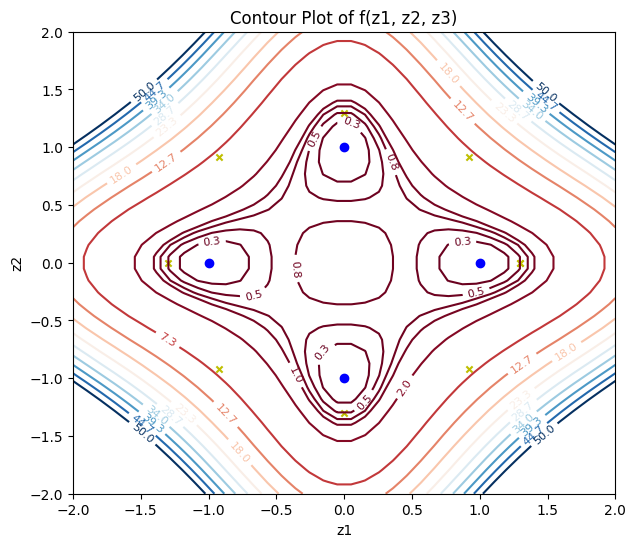

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# # Given points
# z_1 = np.array([1, 1, 1, -1])  # target point
# z_2 = np.array([1, -1, -1, -1])  # target point

# # Compute the midpoint between z_1 and z_2
# midpoint = (z_1 + z_2) / 2

# # Vector between z_1 and z_2
# vector = z_2 - z_1

# # Normalize the vector to use as the axis of rotation
# axis = vector 

# # Define the axes of the elliptical path (semi-major and semi-minor axes)
# a = 0.4 * np.linalg.norm(z_1 - midpoint)  # semi-major axis
# b = 0.2 * np.linalg.norm(z_1 - midpoint)  # semi-minor axis

# # Number of points to generate on the ellipse
# num_points = 10

# print(axis)
# # # Generate the elliptical points in the plane orthogonal to the axis
# # theta = np.linspace(0, 2 * np.pi, num_points)
# # ellipse_points = np.array([
# #     midpoint + (a * np.cos(t) * np.array([0, axis[1], 0, 0]) +
# #                 b * np.sin(t) * np.array([0, 0, axis[2], 0]))
# #     for t in theta
# # ])

# # Generate the elliptical points in the plane orthogonal to the axis
# theta = np.linspace(0, 2 * np.pi, num_points)
# ellipse_points = np.array([
#     midpoint + (a * np.cos(t) * np.array([0, axis[1], 0, 0]) +
#                 b * np.sin(t) * np.array([0, 0, axis[2], 0]))
#     for t in theta
# ])

# # Define the 2D rotation matrix for a 45-degree rotation
# angle = np.radians(-45)
# rotation_matrix = np.array([[1, 0, 0, 0],
#                             [0, np.cos(angle), -np.sin(angle), 0],
#                             [0, np.sin(angle), np.cos(angle), 0], [0, 0, 0, 1]])

# # Apply the rotation to the generated ellipse points in the z1-z2 plane
# ellipse_points = np.array([
#     midpoint + np.dot(rotation_matrix, pt)
#     for pt in ellipse_points
# ])


# Single point at (1, 0, 1, 0)
point_1 = np.array([1, 0, 1, 0])
point_2 = np.array([1, 1, 0, 0])
point_3 = np.array([1, 0, -1, 0])
point_4 = np.array([1, -1, 0, 0])

# Number of points to generate on the circle
num_points = 9

# Generate points on the circle (x-0)^2 + (y-1)^2 = 1
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.array([
    np.array([1, 1.3*np.cos(t), 1.3*np.sin(t) , 0])
    for t in theta
])



# Create a grid for z1 and z2 (both real)
z1_range = np.linspace(-2, 2, 40)
z2_range = np.linspace(-2, 2, 40)
z1_grid, z2_grid = np.meshgrid(z1_range, z2_range)

# Calculate the cost function values over the grid
f_values = np.zeros_like(z1_grid)
for i in range(z1_grid.shape[0]):
    for j in range(z1_grid.shape[1]):
        z1 = z1_grid[i, j]
        z2 = z2_grid[i, j]
        f_values[i, j] = cost_function_or([1,z1, z2, 0])

        
# Define 10 contour levels below 10 and 10 levels above 10
levels_below_10 = np.linspace(f_values.min(), 1, 5)
levels_above_10 = np.linspace(2, 50, 10)
print(f_values.min())
# Combine both level sets
levels_combined = np.concatenate((levels_below_10, levels_above_10))

# levels_combined = np.linspace(f_values.min(), 120, 10)
# Plot the contour
plt.figure(figsize=(7,6))
# contour = plt.contourf(z1_grid, z2_grid, f_values, levels=50, cmap='RdBu')
contour = plt.contour(z1_grid, z2_grid, f_values, levels=levels_combined, cmap='RdBu')
# Label the contour lines
plt.clabel(contour, inline=True, fontsize=8, fmt="%.1f")

# For visualization in 3D, we only consider the first three coordinates
# plt.scatter(z_1[1], z_1[2], color='b', label='z_1')
plt.scatter(point_1[1], point_1[2], color='b', label='opt')
plt.scatter(point_2[1], point_2[2], color='b', label='opt')
plt.scatter(point_3[1], point_3[2], color='b', label='opt')
plt.scatter(point_4[1], point_4[2], color='b', label='opt')
plt.scatter(circle_points[:, 1], circle_points[:, 2], color='y',marker='x',s=20, label='Circle Points')


# plt.scatter(z_1[1], z_1[2], color='r', marker='o', s=100, label='z_1')  # Red circles, size 100
# plt.scatter(z_2[1], z_2[2], color='g', marker='^', s=100, label='z_2')  # Green triangles, size 100
# plt.scatter(ellipse_points[:, 1], ellipse_points[:, 2], color='y', marker='x', s=50, label='Ellipse Points')  # Yellow crosses, size 50



# plt.colorbar(contour, label='f(z1, z2, z3)')
plt.title('Contour Plot of f(z1, z2, z3)')
plt.xlabel('z1')
plt.ylabel('z2')
plt.savefig("example2_landscape.pdf", format='pdf', bbox_inches='tight')

plt.show()

not neceesseary here

Then, using quantum gradient algorithm, we can obtain an updated $|z'\rangle$ and process the simulation


The gradient operator is 
    \begin{eqnarray}
        D(z)=Tr_{1} (A (|z\rangle\langle z|\otimes I))  |z\rangle 
    \end{eqnarray}

plot

C:\Users\Mac\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
C:\Users\Mac\AppData\Local\Temp\ipykernel_11216\2294564958.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  average_cost_values_with[0] = cost_function_or(state_in)


Iteration: 5, cost: 0.9435+0.0000j
Iteration: 10, cost: 0.0707+0.0000j
Iteration: 15, cost: 0.0158+0.0000j
Iteration: 20, cost: 0.0117+0.0000j
Iteration: 25, cost: 0.0011+0.0000j
Iteration: 30, cost: 0.0006+0.0000j
Iteration: 35, cost: 0.0001+0.0000j
Iteration: 40, cost: 0.0000+0.0000j
Iteration: 45, cost: 0.0000+0.0000j
Iteration: 50, cost: 0.0000+0.0000j
Iteration: 55, cost: 0.0000+0.0000j
Iteration: 60, cost: 0.0000+0.0000j
Iteration: 65, cost: 0.0000+0.0000j
Iteration: 70, cost: 0.0000+0.0000j
Iteration: 75, cost: 0.0000+0.0000j
Iteration: 80, cost: 0.0000+0.0000j
Iteration: 85, cost: 0.0000+0.0000j
Iteration: 90, cost: 0.0000+0.0000j
Iteration: 95, cost: 0.0000+0.0000j
Iteration: 100, cost: 0.0000+0.0000j
Iteration: 105, cost: 0.0000+0.0000j
Iteration: 110, cost: 0.0000+0.0000j
Iteration: 115, cost: 0.0000+0.0000j
Iteration(Quantum, No Disturbance): 118, cost: 0.0204+0.0000j, z1: 1.1012+0.0000j, z2: 0.0000+0.0000j, z3: 0.0000+0.0000j
Iteration(Quantum, No Disturbance): 120, cost: 

C:\Users\Mac\AppData\Local\Temp\ipykernel_11216\2294564958.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  average_cost_values_with[0] = cost_function_or(state_in)
C:\Users\Mac\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


 fidelity after PQC : 0.9858
cost: 1.0229+0.0000j
Initial fidelity : 0.9894: 
 fidelity after PQC : 1.0000
cost: 0.6241+0.0000j
Initial fidelity : 0.9977: 
 fidelity after PQC : 0.9977
cost: 0.5372+0.0000j
Initial fidelity : 0.9994: 
 fidelity after PQC : 0.9994
cost: 0.5122+0.0000j
Initial fidelity : 0.9999: 
 fidelity after PQC : 0.9999
cost: 0.5044+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5017-0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5007-0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5003+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5001+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5000+0.0000j
Iteration: 5, cost: 0.9598+0.0000j
Iteration: 10, cost: 0.3084+0.0000j
Iteration: 15, cost: 0.2150+0.0000j
Iteration: 20, cost: 0.1441+0.0000j
Iteration: 25, cost: 0.0260+0.0000j
Iteration: 30, cost: 0.0116+0.0000j
Iteration: 35, cost: 0.0049+0.000

C:\Users\Mac\AppData\Local\Temp\ipykernel_11216\2294564958.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  average_cost_values_with[0] = cost_function_or(state_in)
C:\Users\Mac\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


 fidelity after PQC : 1.0000
cost: 0.6718+0.0000j
Initial fidelity : 0.9964: 
 fidelity after PQC : 0.9964
cost: 0.5388+0.0000j
Initial fidelity : 0.9995: 
 fidelity after PQC : 0.9995
cost: 0.5125+0.0000j
Initial fidelity : 0.9999: 
 fidelity after PQC : 0.9999
cost: 0.5048+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5019+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5008+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5003+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5001+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5001+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5000+0.0000j
Iteration: 5, cost: 0.0156+0.0000j
Iteration: 10, cost: 0.0598+0.0000j
Iteration: 15, cost: 0.0077+0.0000j
Iteration: 20, cost: 0.0014+0.0000j
Iteration: 25, cost: 0.0013+0.0000j
Iteration: 30, cost: 0.0006+0.0000j
Iteration: 35, cost: 0.0004+0.000

C:\Users\Mac\AppData\Local\Temp\ipykernel_11216\2294564958.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  average_cost_values_with[0] = cost_function_or(state_in)
C:\Users\Mac\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


 fidelity after PQC : 1.0000
cost: 0.6721+0.0000j
Initial fidelity : 0.9964: 
 fidelity after PQC : 0.9964
cost: 0.5388-0.0000j
Initial fidelity : 0.9995: 
 fidelity after PQC : 0.9995
cost: 0.5126+0.0000j
Initial fidelity : 0.9999: 
 fidelity after PQC : 0.9999
cost: 0.5048-0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5019-0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5008-0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5003+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5001+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5001+0.0000j
Initial fidelity : 1.0000: 
 fidelity after PQC : 1.0000
cost: 0.5000-0.0000j
Iteration: 5, cost: 0.5362+0.0000j
Iteration: 10, cost: 0.0386+0.0000j
Iteration: 15, cost: 0.0270+0.0000j
Iteration: 20, cost: 0.0096+0.0000j
Iteration: 25, cost: 0.0053+0.0000j
Iteration: 30, cost: 0.0034+0.0000j
Iteration: 35, cost: 0.0017+0.000

C:\Users\Mac\AppData\Local\Temp\ipykernel_11216\2294564958.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  average_cost_values_with[0] = cost_function_or(state_in)
C:\Users\Mac\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
C:\Users\Mac\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Mac\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


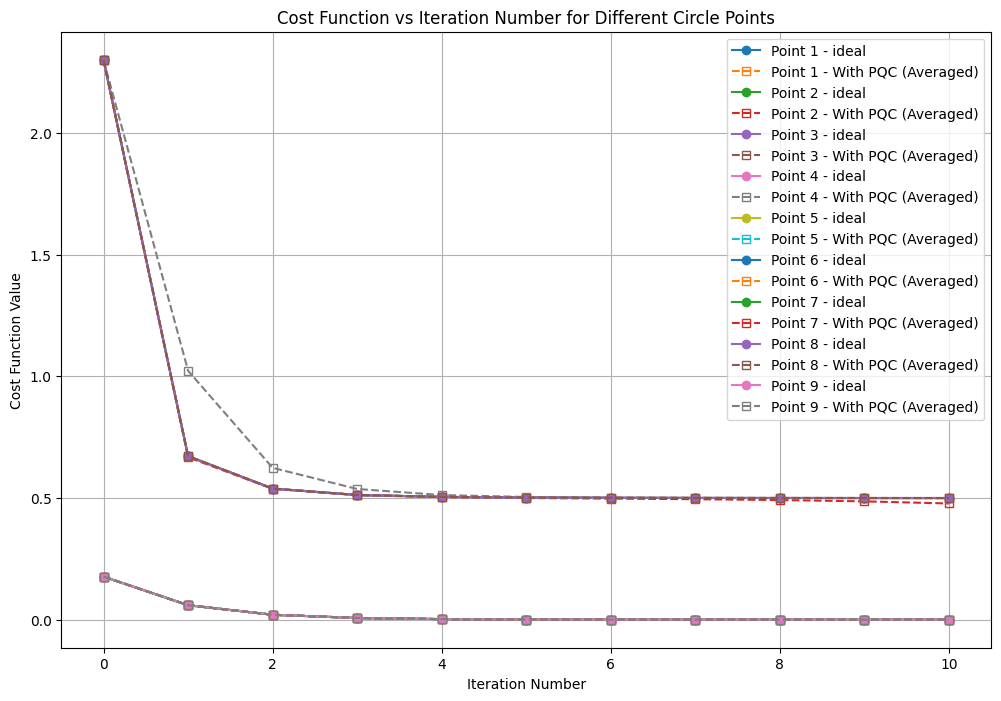

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming functions construct_A, initial_function, create_quantum_circuit,
# cost_function_or, gradient_operator, and disturb_state are already defined

A = construct_A()
xi = 0.2
termination_number = 10
num_runs = 1  # Number of runs to average over

# To store cost values for each circle point in both scenarios
cost_values_without_disturbance = []
cost_values_with_disturbance = []

for ii in range(len(circle_points)):
    # Global iteration counter
    iteration_counter = 0    

    # Optimize using scipy
    p = 1  # Number of layers
    initial_params = np.random.rand(4*p)  # Initial guess for gamma and beta
    z_t = circle_points[ii]

    initial_state = np.array([1/2, 1/2, 1/2, 1/2]) 

    result = minimize(initial_function, initial_params, args=(initial_state, p, z_t,), method='COBYLA')
    initial_p = result.x

    # Initialize state
    state_in = create_quantum_circuit(initial_p, initial_state, p)
    
    # Lists to store cost values for this circle point
    cost_values_per_point_without = [cost_function_or(state_in)]
    average_cost_values_with = np.zeros(termination_number + 1)

    # Without disturbance
    for jj in range(termination_number):
        state_out = state_in - gradient_operator(state_in, A, xi)
        state_out = state_out / np.linalg.norm(state_out)
        state_in = state_out
        
        # Store the cost function value
        cost_value = cost_function_or(state_out)
        cost_values_per_point_without.append(cost_value)
        
        iteration_counter += 1
        if iteration_counter % 2 == 0:
            z1 = state_in[1] / state_in[0]
            z2 = state_in[2] / state_in[0]
            z3 = state_in[3] / state_in[0]
            print(f'Iteration(Quantum, No Disturbance): {iteration_counter}, cost: {cost_value:.4f}, z1: {z1:.4f}, z2: {z2:.4f}, z3: {z3:.4f}')

    # Re-initialize state
    state_in = create_quantum_circuit(initial_p, initial_state, p)

    # With disturbance, averaged over multiple runs
    for run in range(num_runs):
        if run % 5 == 0: print(f'Iteration {run}:')

        state_in_run = state_in
        for jj in range(termination_number):
            state_out = state_in_run - gradient_operator(state_in_run, A, xi)
            state_out = state_out / np.linalg.norm(state_out)
            # state_in_run = disturb_state(state_out, disturbance_magnitude=3e-2) #################### replace 
            print('Initial fidelity : {:.4f}: '.format(fidelity(state_out, state_in_run)))
            _f = fidelity(state_out, state_in_run)
            if _f > 0.999:
                state_in_run, fidelity_j = state_out, _f
            else:
                state_in_run, fidelity_j = get_PQC_state(state_in_run, state_out,env_name='BasicTwoQubit-v0', fidelity_threshold=0.999)
            print(' fidelity after PQC : {:.4f}'.format(fidelity_j))
            # Store the cost function value
            expectation_value = cost_function_or(state_in_run)
            print(f'cost: {expectation_value:.4f}')
            average_cost_values_with[jj + 1] += expectation_value.real
        
    # Average the cost values across the runs
    average_cost_values_with /= num_runs
    average_cost_values_with[0] = cost_function_or(state_in)


    # Add the cost values for this point to the main lists
    cost_values_without_disturbance.append(cost_values_per_point_without)
    cost_values_with_disturbance.append(average_cost_values_with.tolist())

# Plotting the cost function values over iterations for each circle point
plt.figure(figsize=(12, 8))

for idx in range(len(circle_points)):
    plt.plot(range(termination_number + 1), cost_values_without_disturbance[idx], label=f'Point {idx+1} - ideal', linestyle='-', marker='o')
    plt.plot(range(termination_number + 1), cost_values_with_disturbance[idx], label=f'Point {idx+1} - With PQC (Averaged)', linestyle='--', marker='s',markerfacecolor='None')

plt.title('Cost Function vs Iteration Number for Different Circle Points')
plt.xlabel('Iteration Number')
plt.ylabel('Cost Function Value')
plt.legend()
plt.grid(True)
plt.savefig("example2_2_x02_numrun1.pdf", format='pdf', bbox_inches='tight')

plt.show()


In [7]:
len(circle_points)

13